In [ ]:
### wind power generation in Germany

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from catboost import CatBoostRegressor as cbr
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head(5)

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [6]:
df.tail()

,dt,MW
385561,2021-12-30 06:45:00,8140.31
385562,2021-12-30 07:00:00,8162.33
385563,2021-12-30 07:15:00,8405.11
385564,2021-12-30 07:30:00,8503.48
385565,2021-12-30 07:45:00,8403.53


In [7]:
print(df.shape)

(385566, 2)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [9]:
# deep copy to avoid altering the original datset
df1 = df.copy(deep=True)

In [10]:
df1.head(5)

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [11]:
df1.tail()

,dt,MW
385561,2021-12-30 06:45:00,8140.31
385562,2021-12-30 07:00:00,8162.33
385563,2021-12-30 07:15:00,8405.11
385564,2021-12-30 07:30:00,8503.48
385565,2021-12-30 07:45:00,8403.53


### Basic Statistics

In [12]:
# rename columns and change datatype
df1.rename(columns={ 'dt': 'datetime','MW':'power' }, inplace=True)
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1['power'] = df1['power'].astype('float64')

In [13]:
df1.dtypes

datetime    datetime64[ns]
power              float64
dtype: object

### Duration of Dataset

In [14]:
print(f"The data is available from {df1['datetime'].min()} to {df1['datetime'].max()}")

The data is available from 2011-01-01 00:00:00 to 2021-12-30 07:45:00


In [15]:
days = df1.shape[0]//96
print(f'The number of days of wind power in dataset is {days}')

The number of days of wind power in dataset is 4016


## Remark

* Here we divided by 96 because this dataset has 1 datapoint for every 15 minutes
* 4 datapoints in an hour and 4*24 = 96 datapoints per day

In [16]:
df1.describe()

,power
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [17]:
print(f"The maximum power generated was on \n{df1.loc[df1['power']==df1['power'].max()]}")

The maximum power generated was on 
                  datetime    power
378846 2021-10-21 09:00:00  16727.5


In [18]:
# check for missing values
df1.isnull().sum()

datetime    0
power       0
dtype: int64

### Observation
* No missing values in dataset

### EDA

In [19]:
# adding Time-step feature to the dataset
df1['time-step'] = list(range(df1.shape[0]))

In [20]:
df1['year'] = df1['datetime'].dt.year.astype('string')
df1['month'] = df1['datetime'].dt.month_name()
df1['weekday'] = df1['datetime'].dt.day_name()
df1['hour'] = df1['datetime'].dt.strftime('%H').astype('string')

In [21]:
df1

,datetime,power,time-step,year,month,weekday,hour
0,2011-01-01 00:00:00,3416.00,0,2011,January,Saturday,00
1,2011-01-01 00:15:00,4755.00,1,2011,January,Saturday,00
2,2011-01-01 00:30:00,4939.00,2,2011,January,Saturday,00
3,2011-01-01 00:45:00,4939.00,3,2011,January,Saturday,00
4,2011-01-01 01:00:00,4998.00,4,2011,January,Saturday,01
...,...,...,...,...,...,...,...
385561,2021-12-30 06:45:00,8140.31,385561,2021,December,Thursday,06
385562,2021-12-30 07:00:00,8162.33,385562,2021,December,Thursday,07
385563,2021-12-30 07:15:00,8405.11,385563,2021,December,Thursday,07
385564,2021-12-30 07:30:00,8503.48,385564,2021,December,Thursday,07


In [22]:
df1.weekday.unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

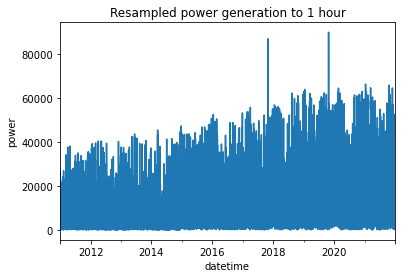

In [23]:
group_df = (df1.set_index('datetime')).resample('H')['power'].sum()
group_df.plot(kind='line')
plt.ylabel('power')
plt.title('Resampled power generation to 1 hour')
plt.show()

* The year 2017 and 2019 have the huge spike in power generated per hour

In [24]:
df1.rename(columns={'power':'power'}, inplace=True)

### Yearly Power generation pattern

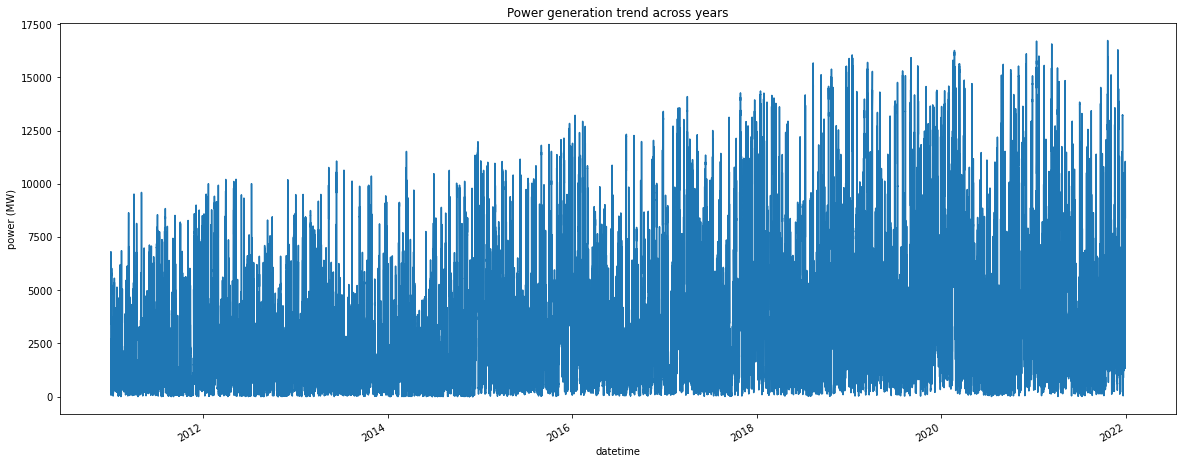

In [25]:
fig, axs = plt.subplots(1,1, figsize=(20,8))
df1.set_index('datetime')['power'].plot()
plt.ylabel('power (MW)')
plt.title('Power generation trend across years')
plt.show()

### Yearly Power increase 

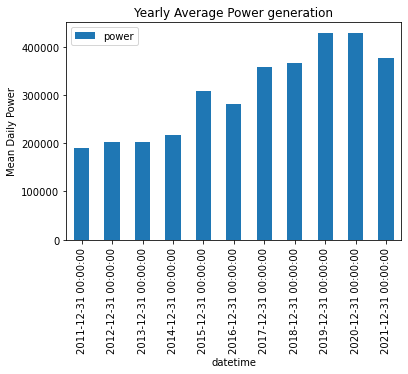

In [26]:
year_df = pd.DataFrame(df1.set_index('datetime').resample('1D')['power'].sum()).resample('1Y').mean()
year_df.plot.bar()
plt.title('Yearly Average Power generation')
plt.ylabel('Mean Daily Power')
plt.show()

* we observe that The power generation has been maximum in 2019 and 2020

### Weekly trend across years

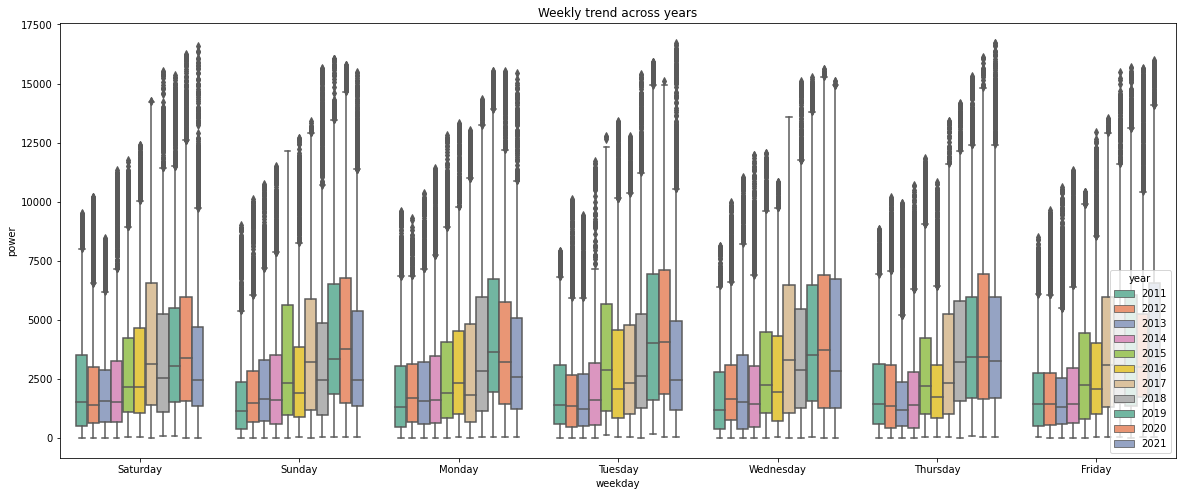

In [27]:
fig, axes = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(data=df1, x='weekday', y='power', hue='year', palette='Set2', ax=axes)
plt.title('Weekly trend across years')
plt.show()

* We observe that the overall sum of power generated on Tuesday, Thursday, Friday, Saturday was high in the year 2021
* The overall sum of power generated on Monday, Sunday was high in the year 2019

### Yearly Growth in Power generation

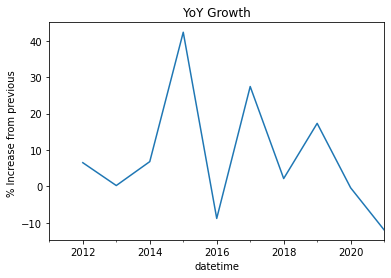

In [28]:
year_df = pd.DataFrame(df1.set_index('datetime').resample('1D')['power'].sum()).resample('1Y').mean()
year_df['shifted'] = year_df.shift(1)
year_df['YoYGrowth'] = ((year_df['power'] - year_df['shifted'])/year_df['shifted'])*100
year_df['YoYGrowth'].plot()
plt.title('YoY Growth')
plt.ylabel('% Increase from previous ')
plt.show()

* we observed that the year 2015 and 2017 have the highest percentage increase in the power compared to the previous year by 35%

### Detect OUtlier

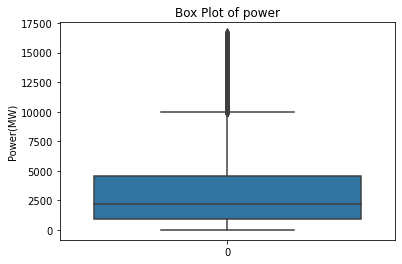

In [29]:
sns.boxplot(data=df1['power'])
plt.title('Box Plot of power')
plt.ylabel('Power(MW)')
plt.show()

* We observed from the box plot, the Power value above 10000 MW are outliers.

In [30]:
# as there are no outliers present users can select any one method to show the same
Q1 = df1.power.quantile(0.25)
Q3 = df1.power.quantile(0.75)
IQR = Q3-Q1
# lower whisker is 0 because power MW is always positive real number
df1['IQR_OUTLIER_FLAG'] = (df1['power'] > (Q3+IQR*1.5)) | (df1['power'] < 0) 
print(F'The upper whisker is {Q3+IQR*1.5}, lower whisker 0 ')
print(f"We have following number of outliers : {df1['IQR_OUTLIER_FLAG'].sum()}")

The upper whisker is 9967.193750000002, lower whisker 0 
We have following number of outliers : 18036


### Feature Engineering

* we will add features like Night, Dawn, Morning, and afternoon to the dataset

In [31]:
df1['monthName '] = df1['datetime'].dt.month
df1['Night '] = (df1['datetime'].dt.hour > 17).astype(int)
df1['Dawn'] = ((df1['datetime'].dt.hour <= 6) & (df1['datetime'].dt.hour >= 0)).astype(int)
df1['Morning '] = ((df1['datetime'].dt.hour > 6)& (df1['datetime'].dt.hour <= 12)).astype(int)
df1['Afternoon '] = ((df1['datetime'].dt.hour > 12) & (df1['datetime'].dt.hour <= 16)).astype(int)

In [32]:
df1.head()

,datetime,power,time-step,year,month,weekday,hour,IQR_OUTLIER_FLAG,monthName,Night,Dawn,Morning,Afternoon
0,2011-01-01 00:00:00,3416.0,0,2011,January,Saturday,00,False,1,0,1,0,0
1,2011-01-01 00:15:00,4755.0,1,2011,January,Saturday,00,False,1,0,1,0,0
2,2011-01-01 00:30:00,4939.0,2,2011,January,Saturday,00,False,1,0,1,0,0
3,2011-01-01 00:45:00,4939.0,3,2011,January,Saturday,00,False,1,0,1,0,0
4,2011-01-01 01:00:00,4998.0,4,2011,January,Saturday,01,False,1,0,1,0,0


* we will onehotencode to add some polynomial features to the data set

In [33]:
# onehot-encode to get polynomial features in the df1 dataset
df1 = pd.get_dummies(df1, prefix='', prefix_sep='')

In [34]:
df1.head()

,datetime,power,time-step,year,hour,IQR_OUTLIER_FLAG,monthName,Night,Dawn,Morning,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2011-01-01 00:00:00,3416.0,0,2011,00,False,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2011-01-01 00:15:00,4755.0,1,2011,00,False,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2011-01-01 00:30:00,4939.0,2,2011,00,False,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,2011-01-01 00:45:00,4939.0,3,2011,00,False,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,2011-01-01 01:00:00,4998.0,4,2011,01,False,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


### Lagging features



In [35]:
for x in [1, 12, 24, 48,72]:
    df1[f'lagged_power_{x}'] = df1['power'].shift(x).bfill()

# build some rolling features like rolling mean
df1['rolling_4_power_mean'] = df1['power'].rolling(4,1).mean().shift().bfill()
df1['rolling_24_power_mean'] = df1['power'].rolling(24, 1).mean().shift().bfill()    

### Choosing Lags - Patial Auto Correlation


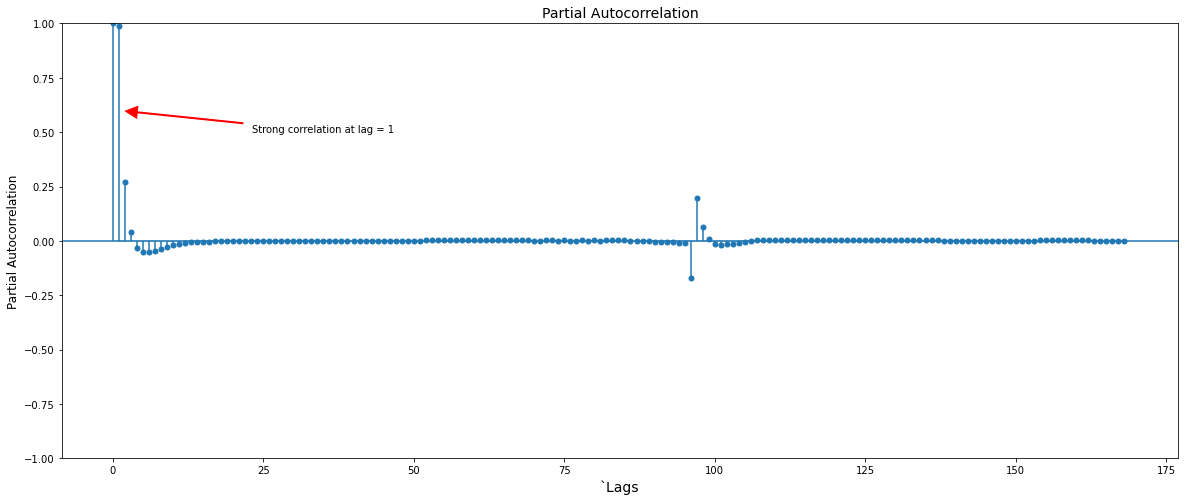

In [36]:
plt.rc('figure', figsize=(20, 8))
plot_pacf(df1['power'], lags=24*7)

plt.annotate('Strong correlation at lag = 1', xy=(1, 0.6), xycoords='data',\
             xytext=(0.17, 0.75), textcoords='axes fraction', \
                arrowprops=dict(color='red', shrink=0.05, width=1))

plt.xlabel('`Lags', fontsize=14)
plt.ylabel('Partial Autocorrelation', fontsize=12)
plt.title(f'Partial Autocorrelation', fontsize=14)
plt.show()

### Autocorrelation

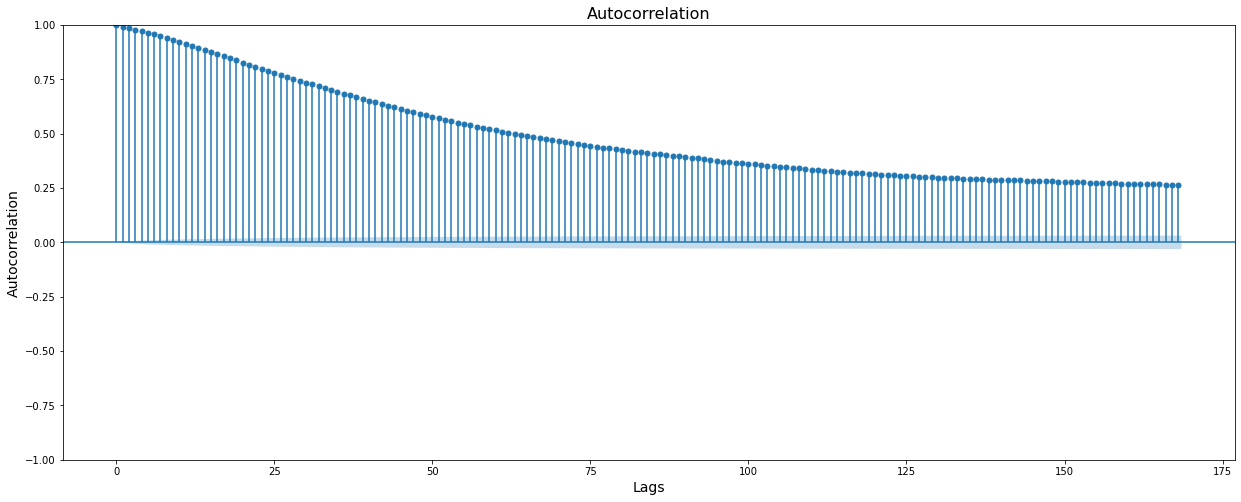

In [37]:
plt.rc('figure', figsize=(21, 8))
plot_acf(df1['power'], lags=24*7)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14)
plt.title(f'Autocorrelation', fontsize=16)
plt.show()


### Correlation

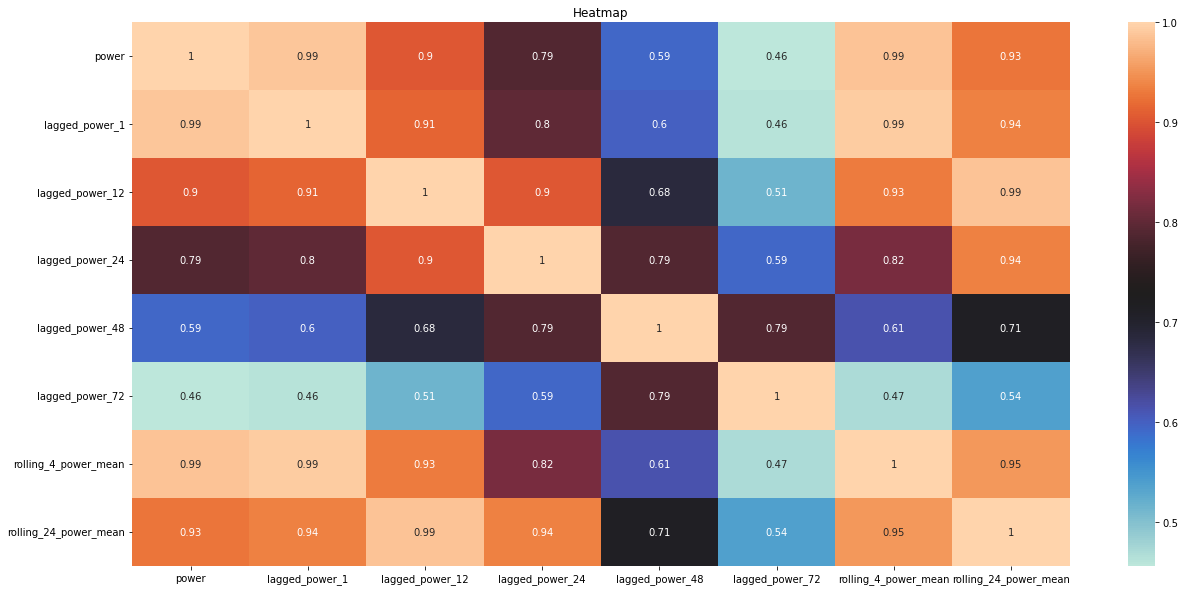

In [38]:
cor = df1.filter(regex='power').corr()
fig,axes = plt.subplots(1,1, figsize=(21, 10))
sns.heatmap(cor, annot=True, cmap='icefire')
plt.title('Heatmap')
plt.show()

* We observed that the lagged_power_1, lagged_power_12, rolling_24_power_mean are the features highly correlated to power feature.
* we also observed that for every 12 timeblocks the power generated trend is similar across the years

In [39]:
print(f'All the features are{df1.columns}')

All the features areIndex(['datetime', 'power', 'time-step', 'year', 'hour', 'IQR_OUTLIER_FLAG',
       'monthName ', 'Night ', 'Dawn', 'Morning ', 'Afternoon ', 'April',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'lagged_power_1', 'lagged_power_12', 'lagged_power_24',
       'lagged_power_48', 'lagged_power_72', 'rolling_4_power_mean',
       'rolling_24_power_mean'],
      dtype='object')


### Modeling

### Forecasting target variable 8 timeblock ahead
The target ahead timeblocks is 8. To forecast for 2 hours ahead => 2*4 = 8 timeblocks


In [40]:
train_data = pd.DataFrame()
target_ahead_timeblocks = 8 # forecasting 2 hours ahead.
df1['ramp'] = df1['power'] - df1['power'].shift(target_ahead_timeblocks)
features = df1.columns.drop(['IQR_OUTLIER_FLAG', 'year', 'hour','ramp'])#, 'month', 'weekday'])
train_data = df1[features].copy()
for feature in train_data.columns:
    train_data[feature] = train_data[feature].shift(-target_ahead_timeblocks)
print(train_data.shape)
train_data.head()    

(385566, 34)


,datetime,power,time-step,monthName,Night,Dawn,Morning,Afternoon,April,August,...,Thursday,Tuesday,Wednesday,lagged_power_1,lagged_power_12,lagged_power_24,lagged_power_48,lagged_power_72,rolling_4_power_mean,rolling_24_power_mean
0,2011-01-01 02:00:00,5509.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5438.0,3416.0,3416.0,3416.0,3416.0,5240.25,4876.250000
1,2011-01-01 02:15:00,5638.0,9.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5509.0,3416.0,3416.0,3416.0,3416.0,5368.00,4946.555556
2,2011-01-01 02:30:00,5582.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5638.0,3416.0,3416.0,3416.0,3416.0,5481.50,5015.700000
3,2011-01-01 02:45:00,5792.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5582.0,3416.0,3416.0,3416.0,3416.0,5541.75,5067.181818
4,2011-01-01 03:00:00,5962.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5792.0,3416.0,3416.0,3416.0,3416.0,5630.25,5127.583333


In [41]:
train_data['target'] = train_data['power'].shift(-target_ahead_timeblocks)

### Data Split


In [42]:

valid_cutoff_date = '2021-01-01 00:00:00' # Validation Cut off
test_cutoff = '2021-06-01 00:00:00' # Test Cut off
x = train_data.drop('target', axis=1).copy()
y = train_data[['datetime', 'target']].copy()


In [43]:
x_train = x[x['datetime'] < valid_cutoff_date].iloc[:, 1:].copy()
y_train = y[y['datetime'] < valid_cutoff_date].iloc[:, 1:].copy()
x_val = x[(x['datetime'] >= valid_cutoff_date) & (x['datetime'] < test_cutoff)].iloc[:, 1:].copy()
y_val = y[(y['datetime'] >= valid_cutoff_date) & (y['datetime'] < test_cutoff)].iloc[:, 1:].copy()
x_test = x[x['datetime'] >= test_cutoff].iloc[:, 1:].copy()
y_test = y[y['datetime'] >= test_cutoff].iloc[:, 1:].copy()

In [44]:
print(f'x train: {x_train.shape}')
print(f'x validation: {x_val.shape}')
print(f'x test: {x_test.shape}')
print(f'y train: {y_train.shape}')
print(f'y validation: {y_val.shape}')
print(f'y test: {y_test.shape}')

x train: (350678, 33)
x validation: (14492, 33)
x test: (20388, 33)
y train: (350678, 1)
y validation: (14492, 1)
y test: (20388, 1)


### Performance metrics

In [45]:
def regression_metrics(y_test, y_pred):
    print('MAE:\t', round(mean_absolute_error(y_test, y_pred), 3))
    print('MSE:\t', round(mean_squared_error(y_test, y_pred), 3))
    print('RMSE:\t', round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
    

Cross Validation -  GridSearchCV

In [46]:
def model_validate(model, param_grid, x_train, y_train, X_test, y_test, 
                   model_name, k_folds=4, scoring='neg_mean_squared_error', fit_parameters={}):
    
    model_cv = GridSearchCV(model, param_grid, cv=k_folds, verbose=False,
                            scoring= scoring, refit=True)
    model_cv.fit(x_train, y_train, **fit_parameters)
    y_train_pred = model_cv.predict(x_train)
    y_test_pred = model_cv.predict(x_test)

    print('Mean Squared Error = ', np.abs(model_cv.score(x_train, y_train)))
    print('Training metrics:')
    regression_metrics(y_train, y_train_pred)

    return model_cv

### Lasso

In [47]:
lasso = Lasso(alpha = 0.0005, random_state=42)
param_grid = [{'alpha':[0.0005,0.001, 0.005, 0.01, 0.05, 0.03, 0.1, 0.5, 1]}]

lasso_model = model_validate(lasso, param_grid, x_train, y_train, x_test, y_test, 'Lasso', k_folds=5)

Mean Squared Error =  980757.4390517178
Training metrics:
MAE:	 572.773
MSE:	 980757.439
RMSE:	 990.332


### CatBoost

In [48]:
cat = cbr(loss_function='RMSE', learning_rate=0.01, max_depth=7, iterations=1500)

catreg = cat.fit(x_train, y_train, verbose_eval=200,plot=True,eval_set=(x_val,y_val))
print('Model trained for horizon {}'.format(target_ahead_timeblocks))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2965.5073417	test: 3588.6844913	best: 3588.6844913 (0)	total: 77.9ms	remaining: 1m 56s
200:	learn: 1078.3066617	test: 1331.4422928	best: 1331.4422928 (200)	total: 2.8s	remaining: 18.1s
400:	learn: 974.8665777	test: 1192.4688032	best: 1192.4688032 (400)	total: 5.67s	remaining: 15.6s
600:	learn: 954.8567228	test: 1170.4304761	best: 1170.4304761 (600)	total: 8.21s	remaining: 12.3s
800:	learn: 941.7038124	test: 1159.6756568	best: 1159.6756568 (800)	total: 11s	remaining: 9.56s
1000:	learn: 931.3533391	test: 1152.6361113	best: 1152.6361113 (1000)	total: 13.5s	remaining: 6.72s
1200:	learn: 922.5897099	test: 1147.4534628	best: 1147.3960796 (1192)	total: 16.1s	remaining: 4s
1400:	learn: 914.6964083	test: 1144.5295306	best: 1144.5130696 (1399)	total: 18.5s	remaining: 1.31s
1499:	learn: 911.0697738	test: 1142.7655177	best: 1142.7320260 (1497)	total: 19.7s	remaining: 0us

bestTest = 1142.732026
bestIteration = 1497

Shrink model to first 1498 iterations.
Model trained for horizon 8


### output

In [49]:
predictions = lasso_model.predict(x_test)
y_test['lasso_prediction'] = predictions

predictions = catreg.predict(x_test)
y_test['cat_boost_prediction'] = predictions

### Forecasted results

Shifting back the time forecast power values by 8 timeblocks

In [50]:
y_test.target = y_test.target.shift(target_ahead_timeblocks)

In [51]:
y_test[len(y_test) - target_ahead_timeblocks: len(y_test)]

,target,lasso_prediction,cat_boost_prediction
385550,8530.69,8902.696485,8811.920641
385551,8603.80,8679.081731,9034.770136
385552,8412.88,8461.734469,8536.246248
385553,8140.31,8132.670330,8359.415959
385554,8162.33,8161.412675,8295.509905
385555,8405.11,8372.903254,8375.828640
385556,8503.48,8521.610557,8625.882148
385557,8403.53,8433.171038,8330.165781


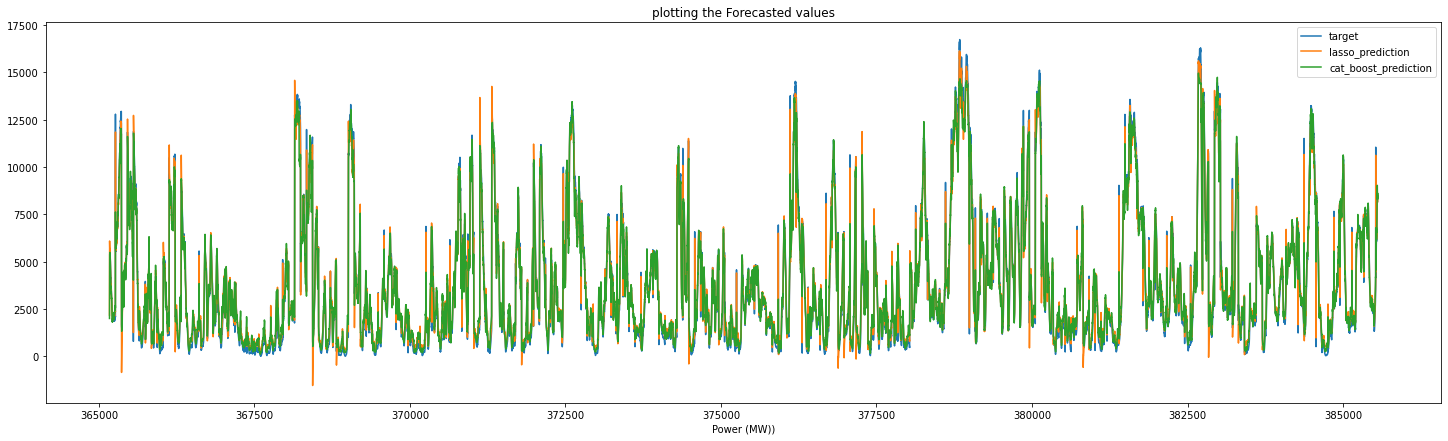

In [52]:
fig, axes = plt.subplots(1,1, figsize=(25, 7))
y_test.plot(ax=axes)
plt.title('plotting the Forecasted values')
plt.xlabel('Power (MW))')
plt.show()

plotting Forecasting results 2 hours(8 time-step ahead).

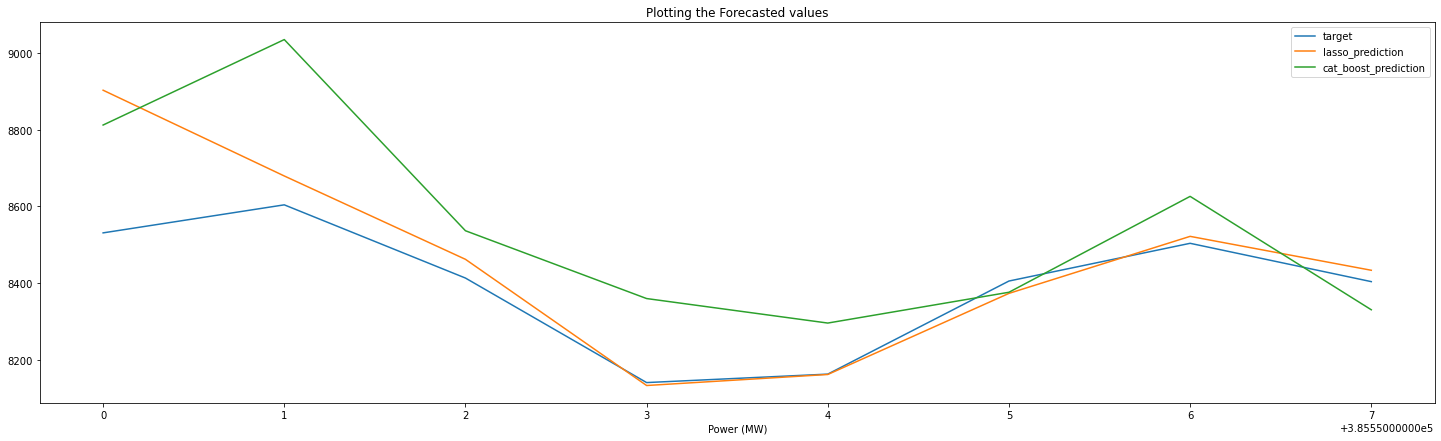

In [53]:
fig, axes = plt.subplots(1,1, figsize=(25,7))
y_test[len(y_test)-target_ahead_timeblocks: len(y_test)].plot(ax=axes)
plt.title('Plotting the Forecasted values')
plt.xlabel('Power (MW)')
plt.show()